# Interactive inference

In [17]:
from models.single_policy import SinglePolicy
from single_agent import SingleAgent
from IPython.display import SVG, display, HTML
import torch
from torch import distributions
import pdb
import vh_graph
import gym
import envdataset
import utils_viz
import utils
import sys
from IPython.display import Image
sys.argv = ['-f'] 

In [18]:
curr_env = gym.make('vh_graph-v0')

In [19]:
ls

belief_example.gv.pdf  Digraph.gv.png               __pycache__/
dataset/               envdataset.py                README.md
dataset_subgoals2@     environment.py               single_agent.py
dataset_subgoals3@     graph_example.gv.pdf         test_belief.py
dataset_toy@           gt_graph.gv.pdf              Testing belief.ipynb
dataset_toy3@          Interactive inference.ipynb  trainer.py
dataset_toy4@          logdir/                      train_script.sh
data_subgoals_small/   models/                      utils.py
Digraph.gv             output_False.json            utils_viz.py
Digraph.gv.pdf         output_True.json             wide.png


In [20]:
weights = 'logdir/dataset_folder.dataset_toy4_pomdp.False_graphsteps.3_training_mode.bc/2019-11-12_21.33.57.388801/chkpt/chkpt_149.pt'

In [21]:
# Set up the policy
args = utils.read_args()
args.max_steps = 1
args.dataset_folder = 'dataset_toy4'
args.interactive = True
dataset_interactive = envdataset.EnvDataset(args, process_progs=False)
print('Starting model...')
policy_net = SinglePolicy(dataset_interactive).cuda()
policy_net = torch.nn.DataParallel(policy_net)
policy_net.eval()
if weights is not None:
    print('Loading weights')
    state_dict = torch.load(weights)
    policy_net.load_state_dict(state_dict['model_params'])

Getting objects from dataset_toy4/obj_names.json...
Starting model...
Loading weights


In [22]:

path_init_env = 'dataset_toy4/init_envs/TrimmedTestScene6_graph_40.json'
goal_name = {0:'(facing living_room[1] living_room[1])'}
curr_env.reset(path_init_env, goal_name)
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)
gt_state = curr_env.vh_state.to_dict()

### Set the goal to find pencil 2026

In [23]:
id_agent = [x['id'] for x in gt_state['nodes'] if x['class_name'] == 'character'][0]
id_goal = 2026
goal_str = 'findnode_{}'.format(id_goal)


## View graph

Edges...


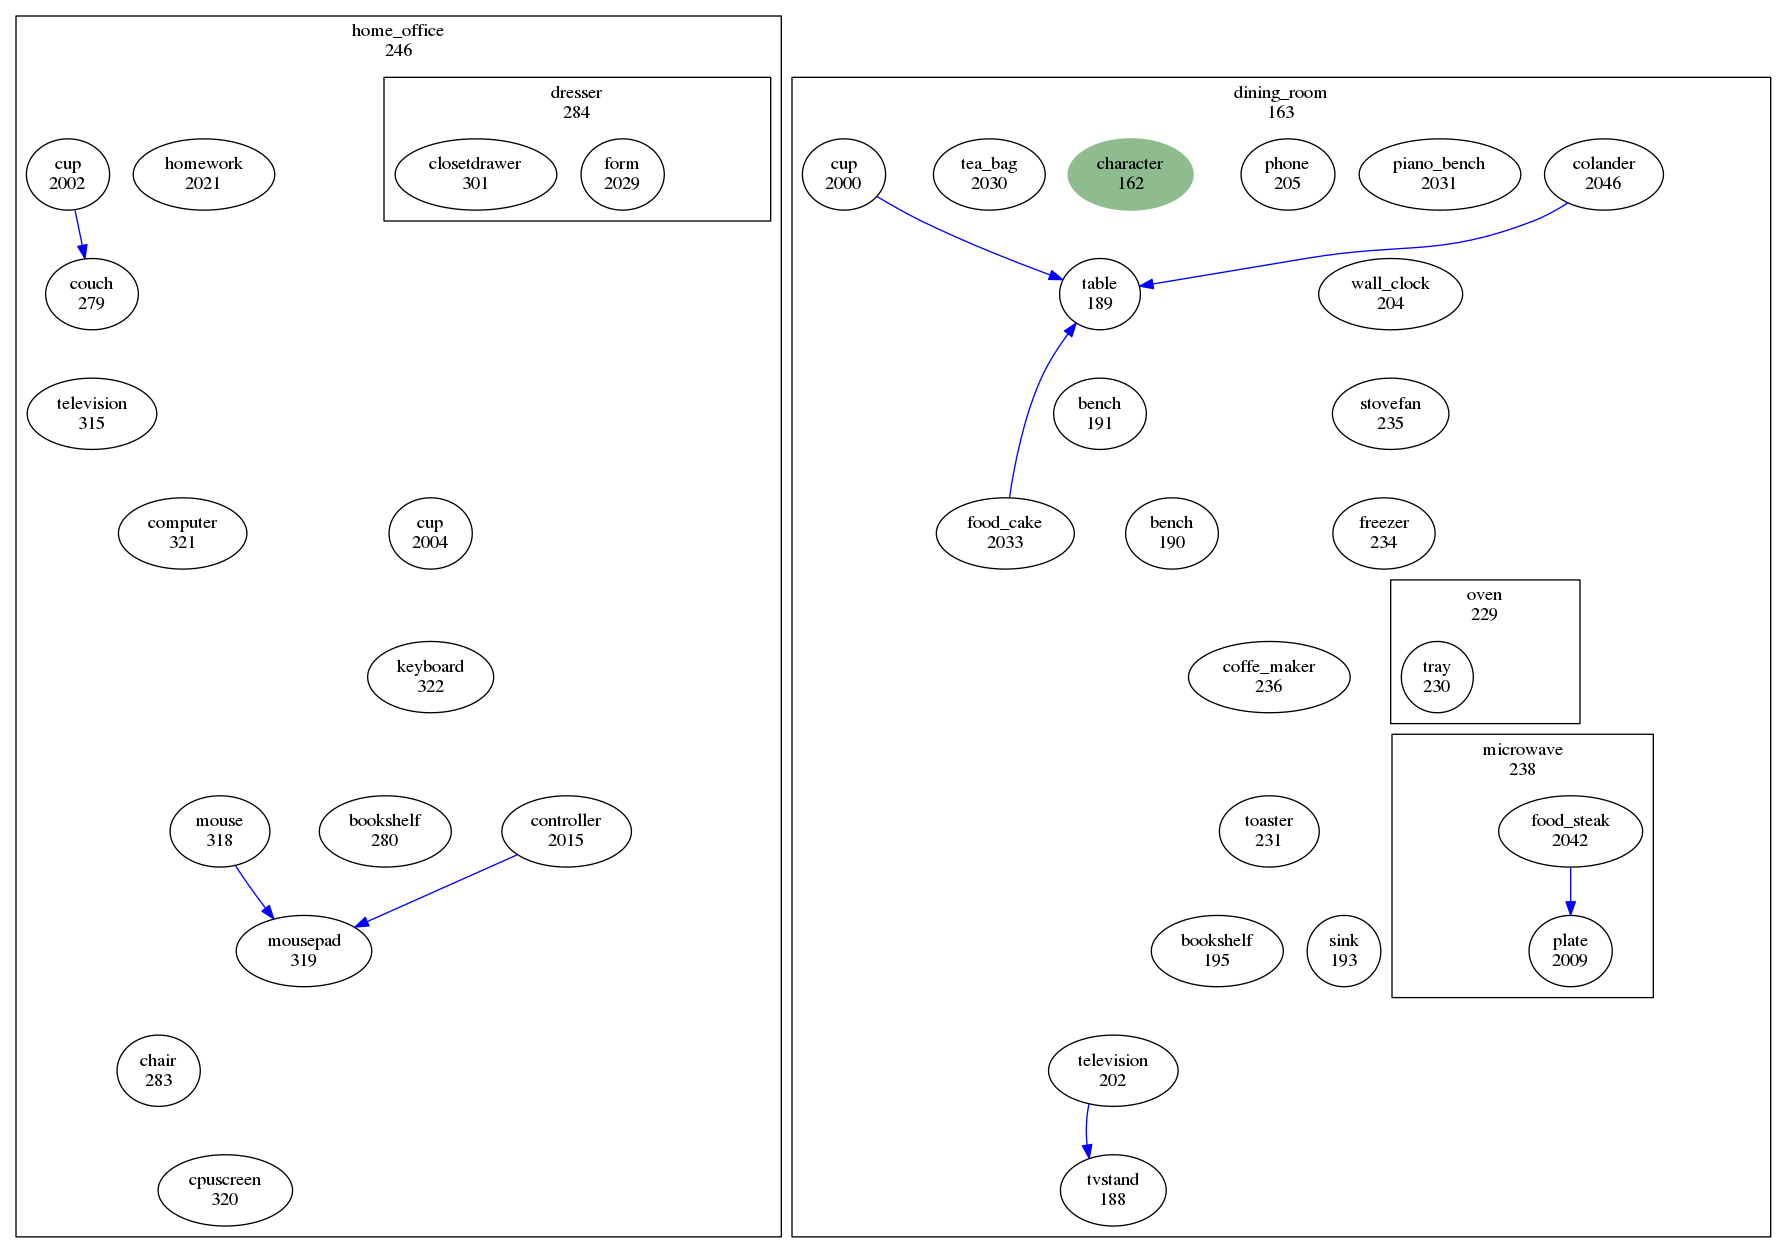

In [24]:
graph = utils_viz.graph2im(gt_state, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

### Explore the model

Edges...


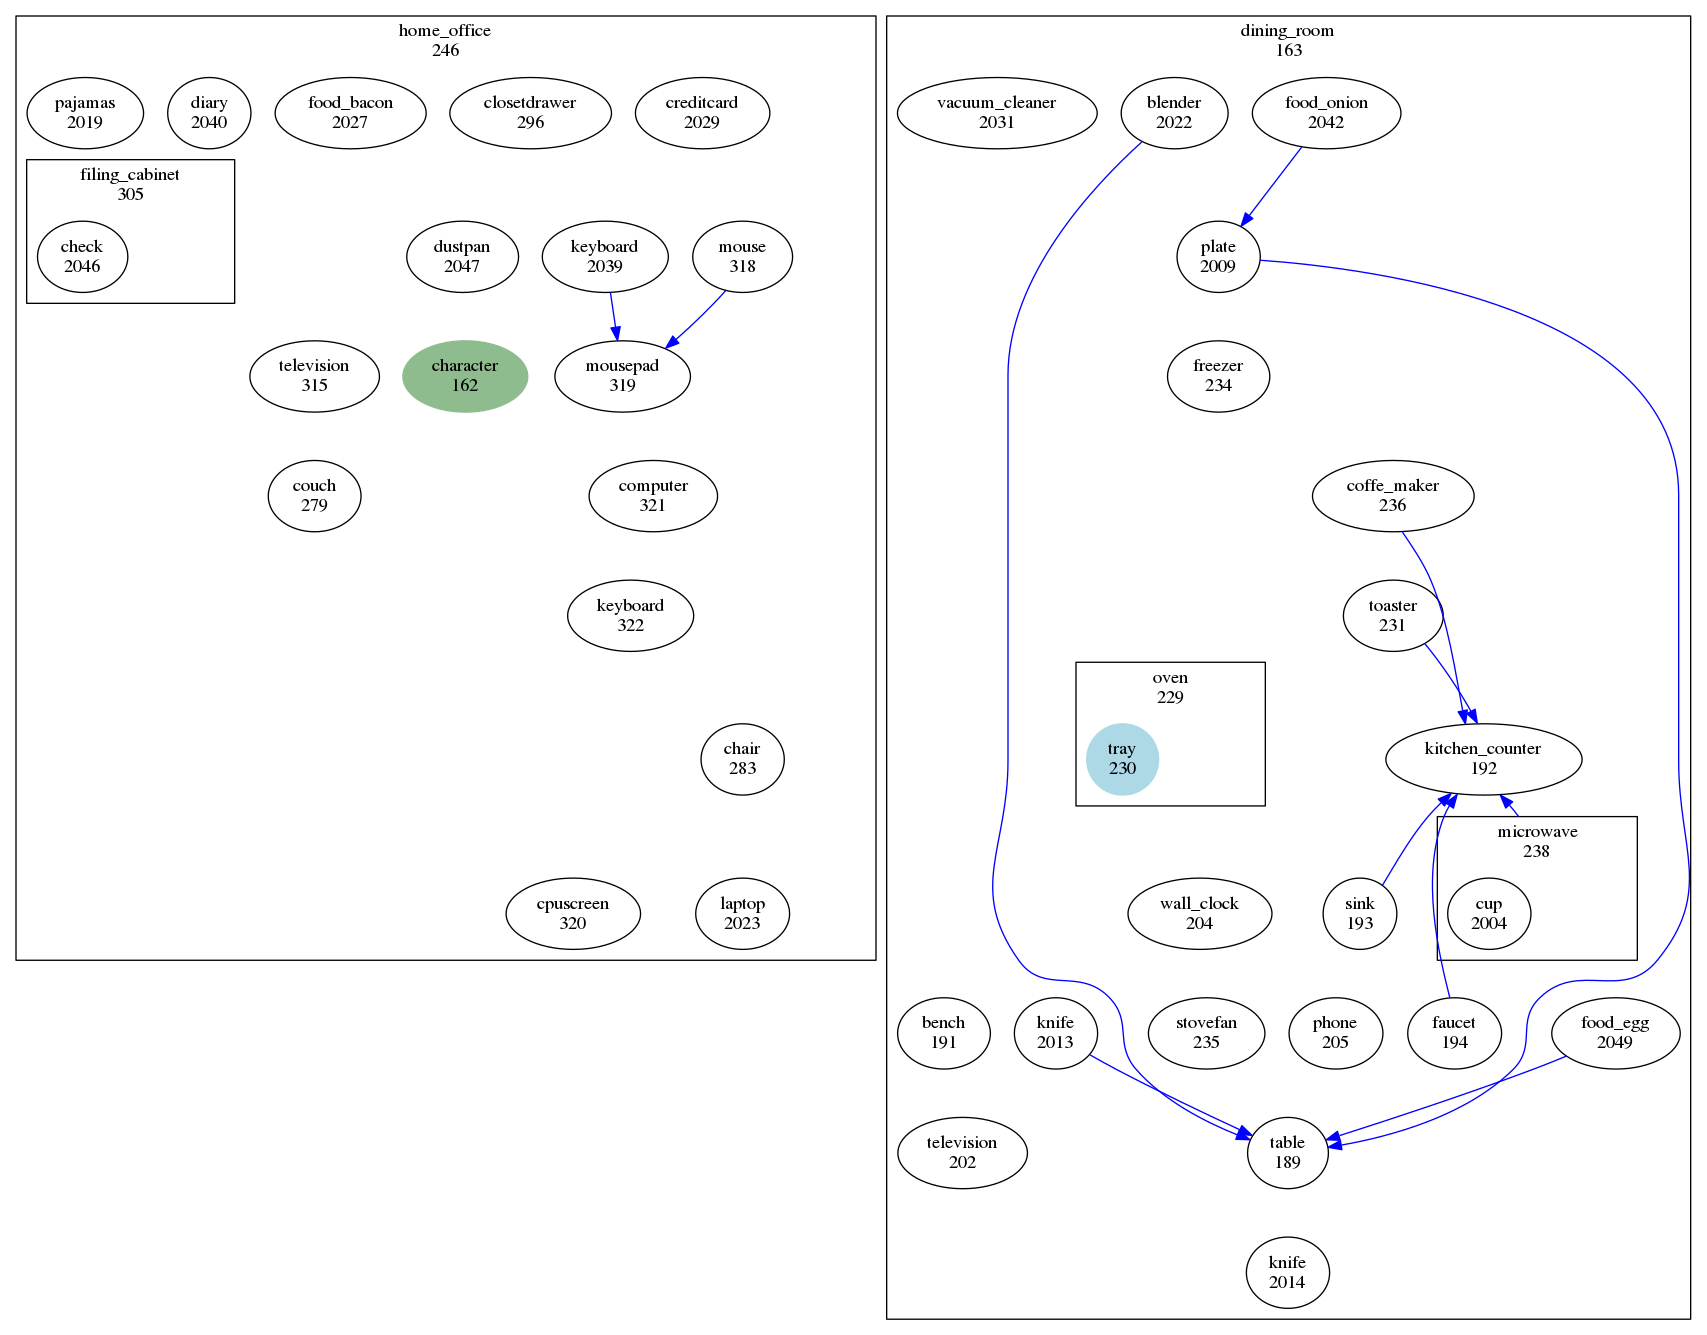

In [25]:
path_init_env = 'dataset_toy4/init_envs/TrimmedTestScene6_graph_45.json'

goal_name = {0:'(facing living_room[1] living_room[1])'}
curr_env.reset(path_init_env, goal_name)
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)
gt_state = curr_env.vh_state.to_dict()


id_agent = [x['id'] for x in gt_state['nodes'] if x['class_name'] == 'character'][0]
id_goal = 230

goal_string = 'findnode_{}'.format(id_goal)
graph = utils_viz.graph2im(gt_state, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))


In [26]:
# POMDP
weights = 'logdir/dataset_folder.dataset_toy4_pomdp.True_graphsteps.3_training_mode.bc/2019-11-13_19.24.37.715547/chkpt/chkpt_149.pt'
single_agent.env.reset(path_init_env, goal_name)
single_agent.policy_net.load_state_dict(torch.load(weights)['model_params'])
goal_string = 'findnode_2046'

# curr_state['edges'].append({'relation_type': 'CLOSE', 'from_id':id_char ,'to_id': 229})
# curr_state['edges'].append({'relation_type': 'CLOSE', 'from_id':id_char ,'to_id': 230})
#curr_state['edges'] = [x for x in curr_state['edges'] if x['relation_type'] != 'CLOSE' or (x['from_id'] == id_char or x['to_id'] == id_char)]
pomdp = True
instr, _, r, _ = single_agent.rollout(goal_string, pomdp, None, 0., True)
print(instr)
print(r)

['[walk] <creditcard> (2029) ', '[walk] <pajamas> (2019) ', '[walk] <creditcard> (2029) ', '[walk] <dining_room> (163) ', '[walk] <home_office> (246) ', '[walk] <creditcard> (2029) ', '[walk] <dining_room> (163) ', '[walk] <home_office> (246) ', '[walk] <dining_room> (163) ', '[walk] <home_office> (246) ']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [27]:

# FOMDP
args.max_steps = 15
single_agent.env.reset(path_init_env, goal_name)
weights = 'logdir/dataset_folder.dataset_toy4_pomdp.False_graphsteps.3_training_mode.pg/offp.False_eps.0.2_gamma.0.7/2019-11-14_00.45.32.080556/chkpt/chkpt_149.pt'
single_agent.policy_net.load_state_dict(torch.load(weights)['model_params'])
pomdp = False
instr, _, r, _ = single_agent.rollout(goal_string, pomdp, None, 0., True)
print(instr)
print(r)
# while step < nsteps and not finished:    
#     curr_state = single_agent.env.vh_state.to_dict()
#     visible_ids = single_agent.env.observable_object_ids_n[0]
#     graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(curr_state, visible_ids, goal_string)
#     instruction, _ = single_agent.sample_instruction(dataset_interactive, graph_data, action_logits, o1_logits, o2_logits, pick_max=True)
#     instr = list(zip(*instruction))[0]
#     str_instruction = utils.pretty_instr(instr)
#     print(str_instruction)
#     if 'stop' in str_instruction:
#         finished = True
#     else:
#         single_agent.env.step({0: str_instruction})
#     step += 1

['[walk] <filing_cabinet> (305) ', '[open] <filing_cabinet> (305) ']
[0, 1]


Getting objects from dataset_toy4/obj_names.json...
Starting model...
Edges...


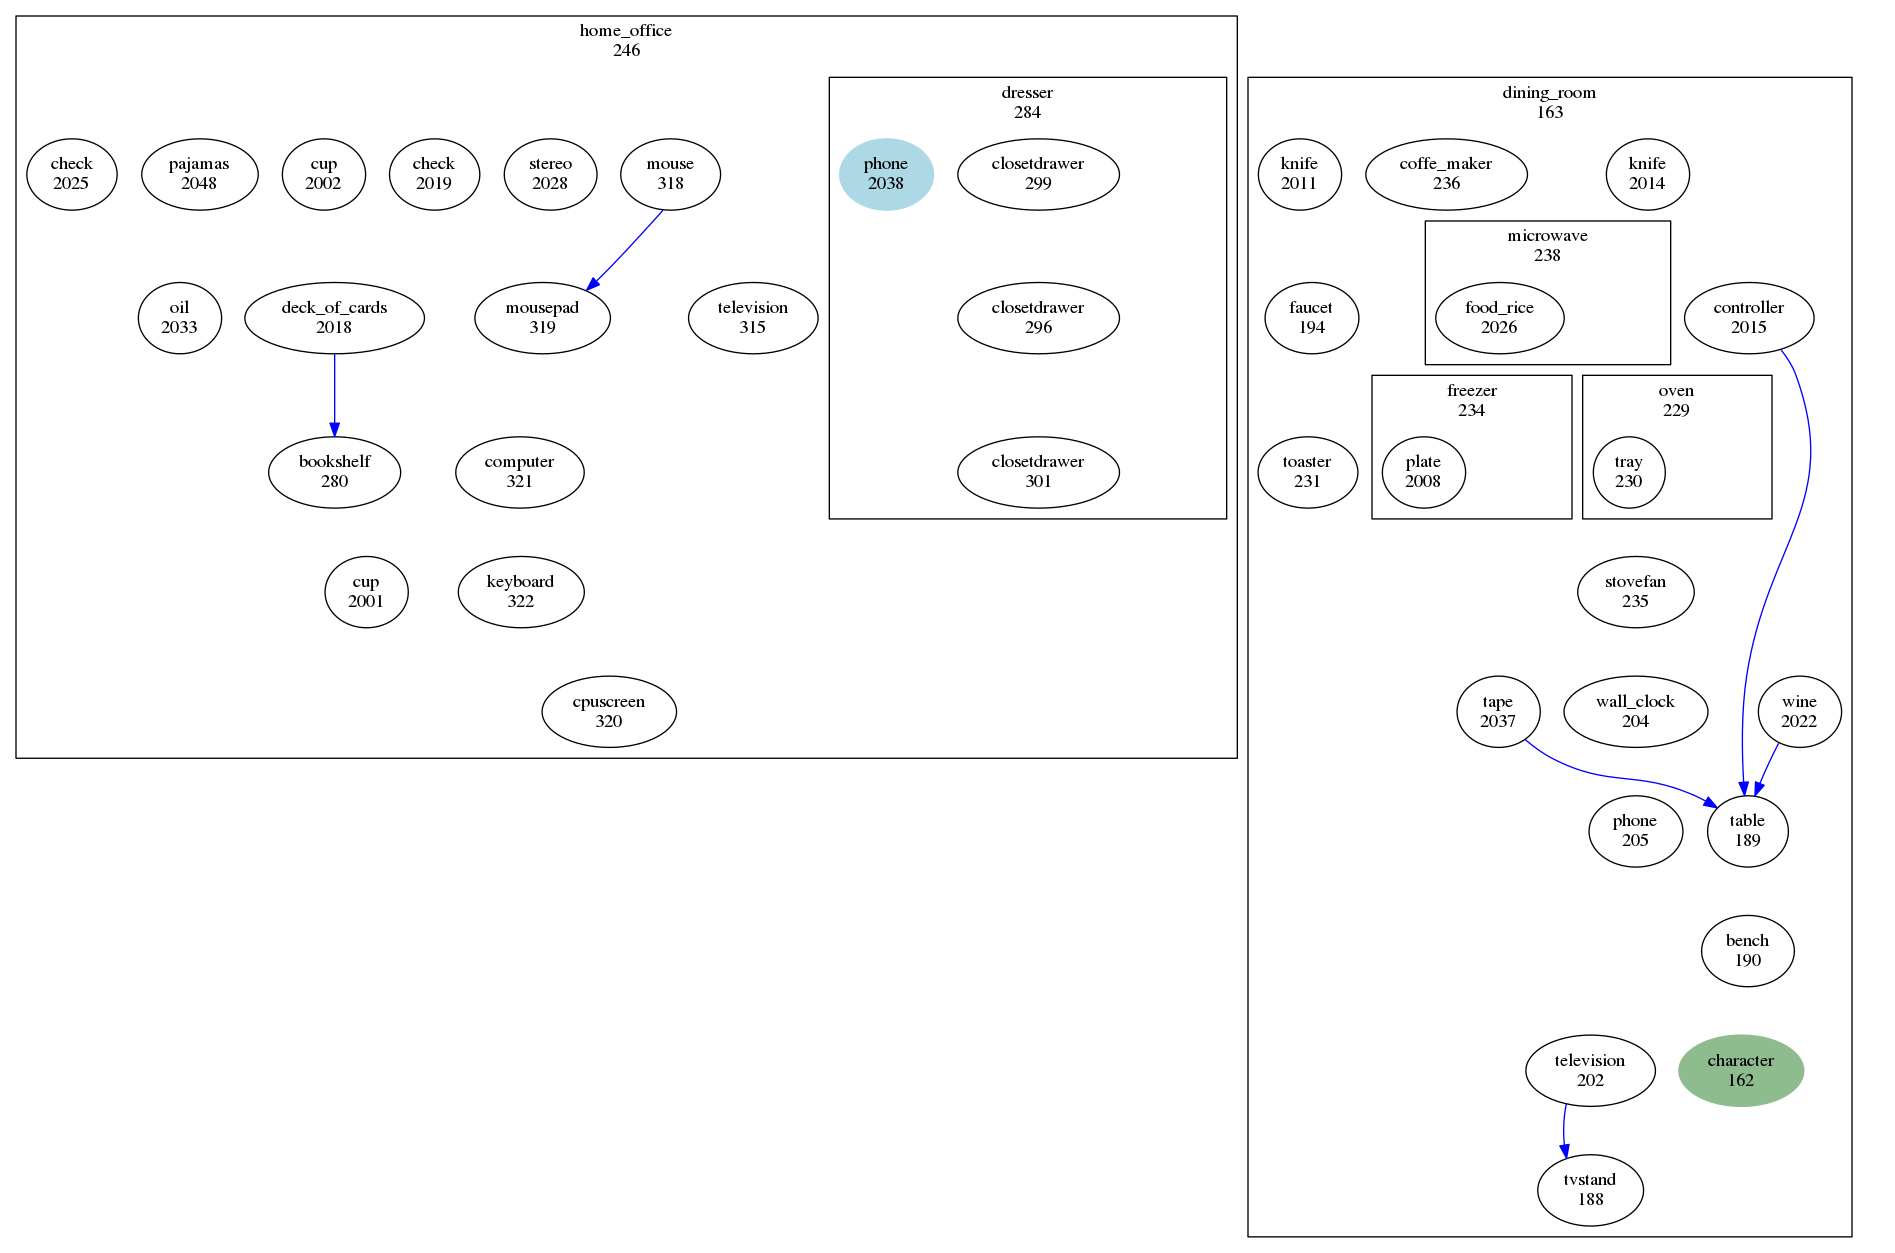

In [28]:
path_init_env = 'dataset_toy4/init_envs/TrimmedTestScene6_graph_35.json'
id_goal = 2038
str_goal = 'findnode_{}'.format(id_goal)
id_agent = 162

args = utils.read_args()
args.max_steps = 1
args.dataset_folder = 'dataset_toy4'
args.interactive = True
dataset_interactive = envdataset.EnvDataset(args, process_progs=False)
print('Starting model...')
policy_net = SinglePolicy(dataset_interactive).cuda()
policy_net = torch.nn.DataParallel(policy_net)
goal_name = {0:'(facing living_room[1] living_room[1])'}
curr_env.reset(path_init_env, goal_name)
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)
single_agent.env.reset(path_init_env, goal_name)
weights = 'logdir/dataset_folder.dataset_toy4_pomdp.False_graphsteps.3_training_mode.pg/offp.False_eps.0.2_gamma.0.7/2019-11-14_00.45.32.080556/chkpt/chkpt_149.pt'
single_agent.policy_net.load_state_dict(torch.load(weights)['model_params'])
single_agent.env.reset(path_init_env, goal_name)
gt_state = single_agent.env.vh_state.to_dict()
graph = utils_viz.graph2im(gt_state, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

## Test tianmin

Sampling
HERE
Done
[{'from_id': 280, 'to_id': 246, 'relation_type': 'INSIDE'}, {'from_id': 2022, 'to_id': 280, 'relation_type': 'INSIDE'}, {'from_id': 2028, 'to_id': 280, 'relation_type': 'INSIDE'}, {'from_id': 2037, 'to_id': 280, 'relation_type': 'INSIDE'}]
> /data/vision/torralba/frames/data_acquisition/SyntheticStories/MultiAgent/vh_multiagent_models/single_agent.py(69)sample_belief()
-> new_graph = self.belief.update_graph_from_gt_graph(obs_graph)
(Pdb) c
UPDATI
> /data/vision/torralba/frames/data_acquisition/SyntheticStories/MultiAgent/vh_mdp/vh_graph/envs/belief.py(248)update_graph_from_gt_graph()
-> id2node = {}
(Pdb) c
> /data/vision/torralba/frames/data_acquisition/SyntheticStories/MultiAgent/vh_mdp/vh_graph/envs/belief.py(295)update_graph_from_gt_graph()
-> self.sampled_graph['edges'] = edges_keep + gt_graph['edges']
(Pdb) c
Edges...


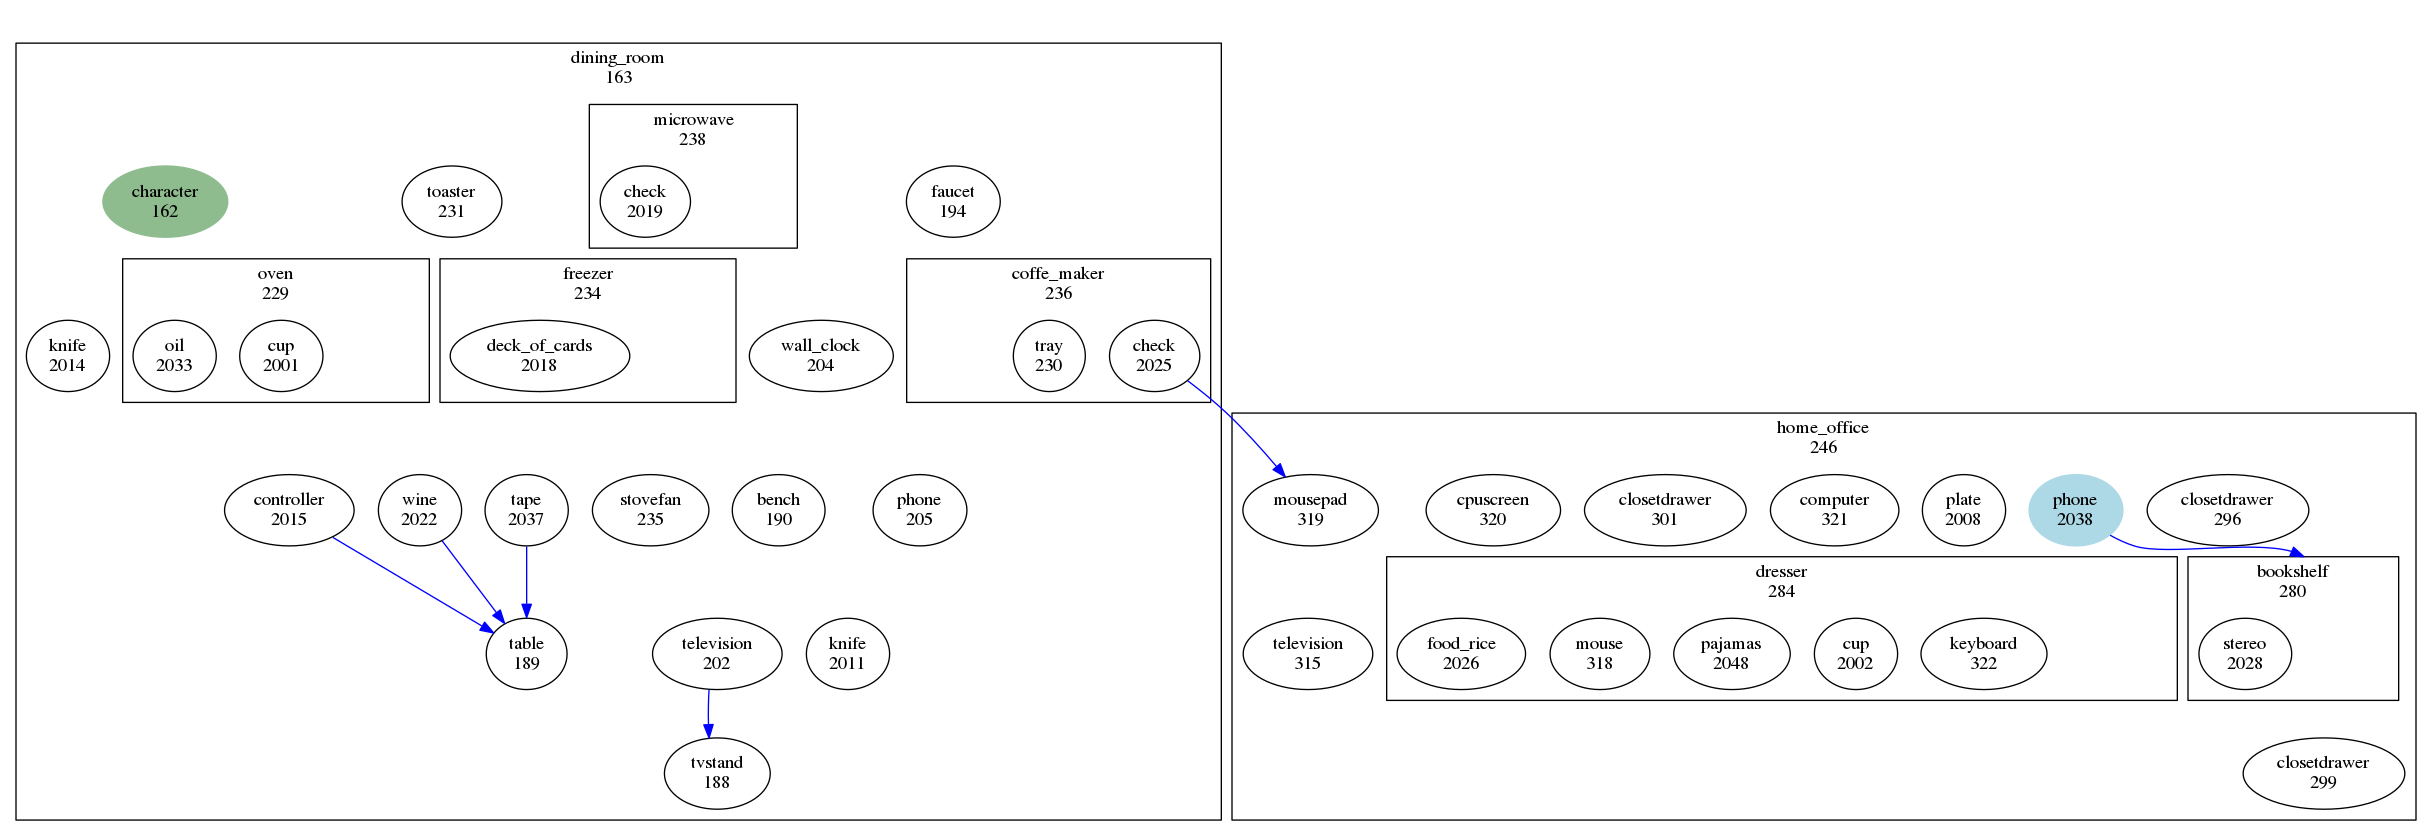

In [29]:
import numpy as np
import random
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
single_agent.previous_belief_graph = None
obs_graph = single_agent.get_observations()
#print([x for x in single_agent.belief.sampled_graph['edges'] if x['to_id'] == 280 or x['from_id'] == 280])
#print([x for x in obs_graph['edges'] if x['to_id'] == 280 or x['from_id'] == 280])
single_agent.sample_belief(obs_graph)

graph = utils_viz.graph2im(single_agent.belief_sim.vh_state.to_dict(), {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()

display(Image(tmp))

In [33]:
observations = single_agent.get_observations()
single_agent.sample_belief(observations)
curr_state = single_agent.belief_sim.vh_state.to_dict()
visible_ids = single_agent.belief_sim.observable_object_ids_n[0]
print(visible_ids)
str_instruction = '[walk] <bench> (190>'
single_agent.env.step({0: str_instruction})
single_agent.belief_sim.step({0: str_instruction})
# graph = utils_viz.graph2im(single_agent.belief_sim.vh_state.to_dict(), {id_goal: 'goal', id_agent: 'agent'})
# graph.format = 'png'
# tmp = graph.view()

display(Image(tmp))

Sampling
UPDATI
> /data/vision/torralba/frames/data_acquisition/SyntheticStories/MultiAgent/vh_mdp/vh_graph/envs/belief.py(248)update_graph_from_gt_graph()
-> id2node = {}
(Pdb) c
> /data/vision/torralba/frames/data_acquisition/SyntheticStories/MultiAgent/vh_mdp/vh_graph/envs/belief.py(295)update_graph_from_gt_graph()
-> self.sampled_graph['edges'] = edges_keep + gt_graph['edges']
(Pdb) c
[163, 188, 189, 190, 194, 202, 204, 205, 229, 231, 234, 235, 236, 238, 246, 2011, 2014, 2015, 2022, 2037, 1099, 162]


ScriptParseException: Wrong number of parameters for "WALK". Got 0, expected 1

# Effect of belief

Getting objects from dataset_toy4/obj_names.json...
Starting model...
Edges...


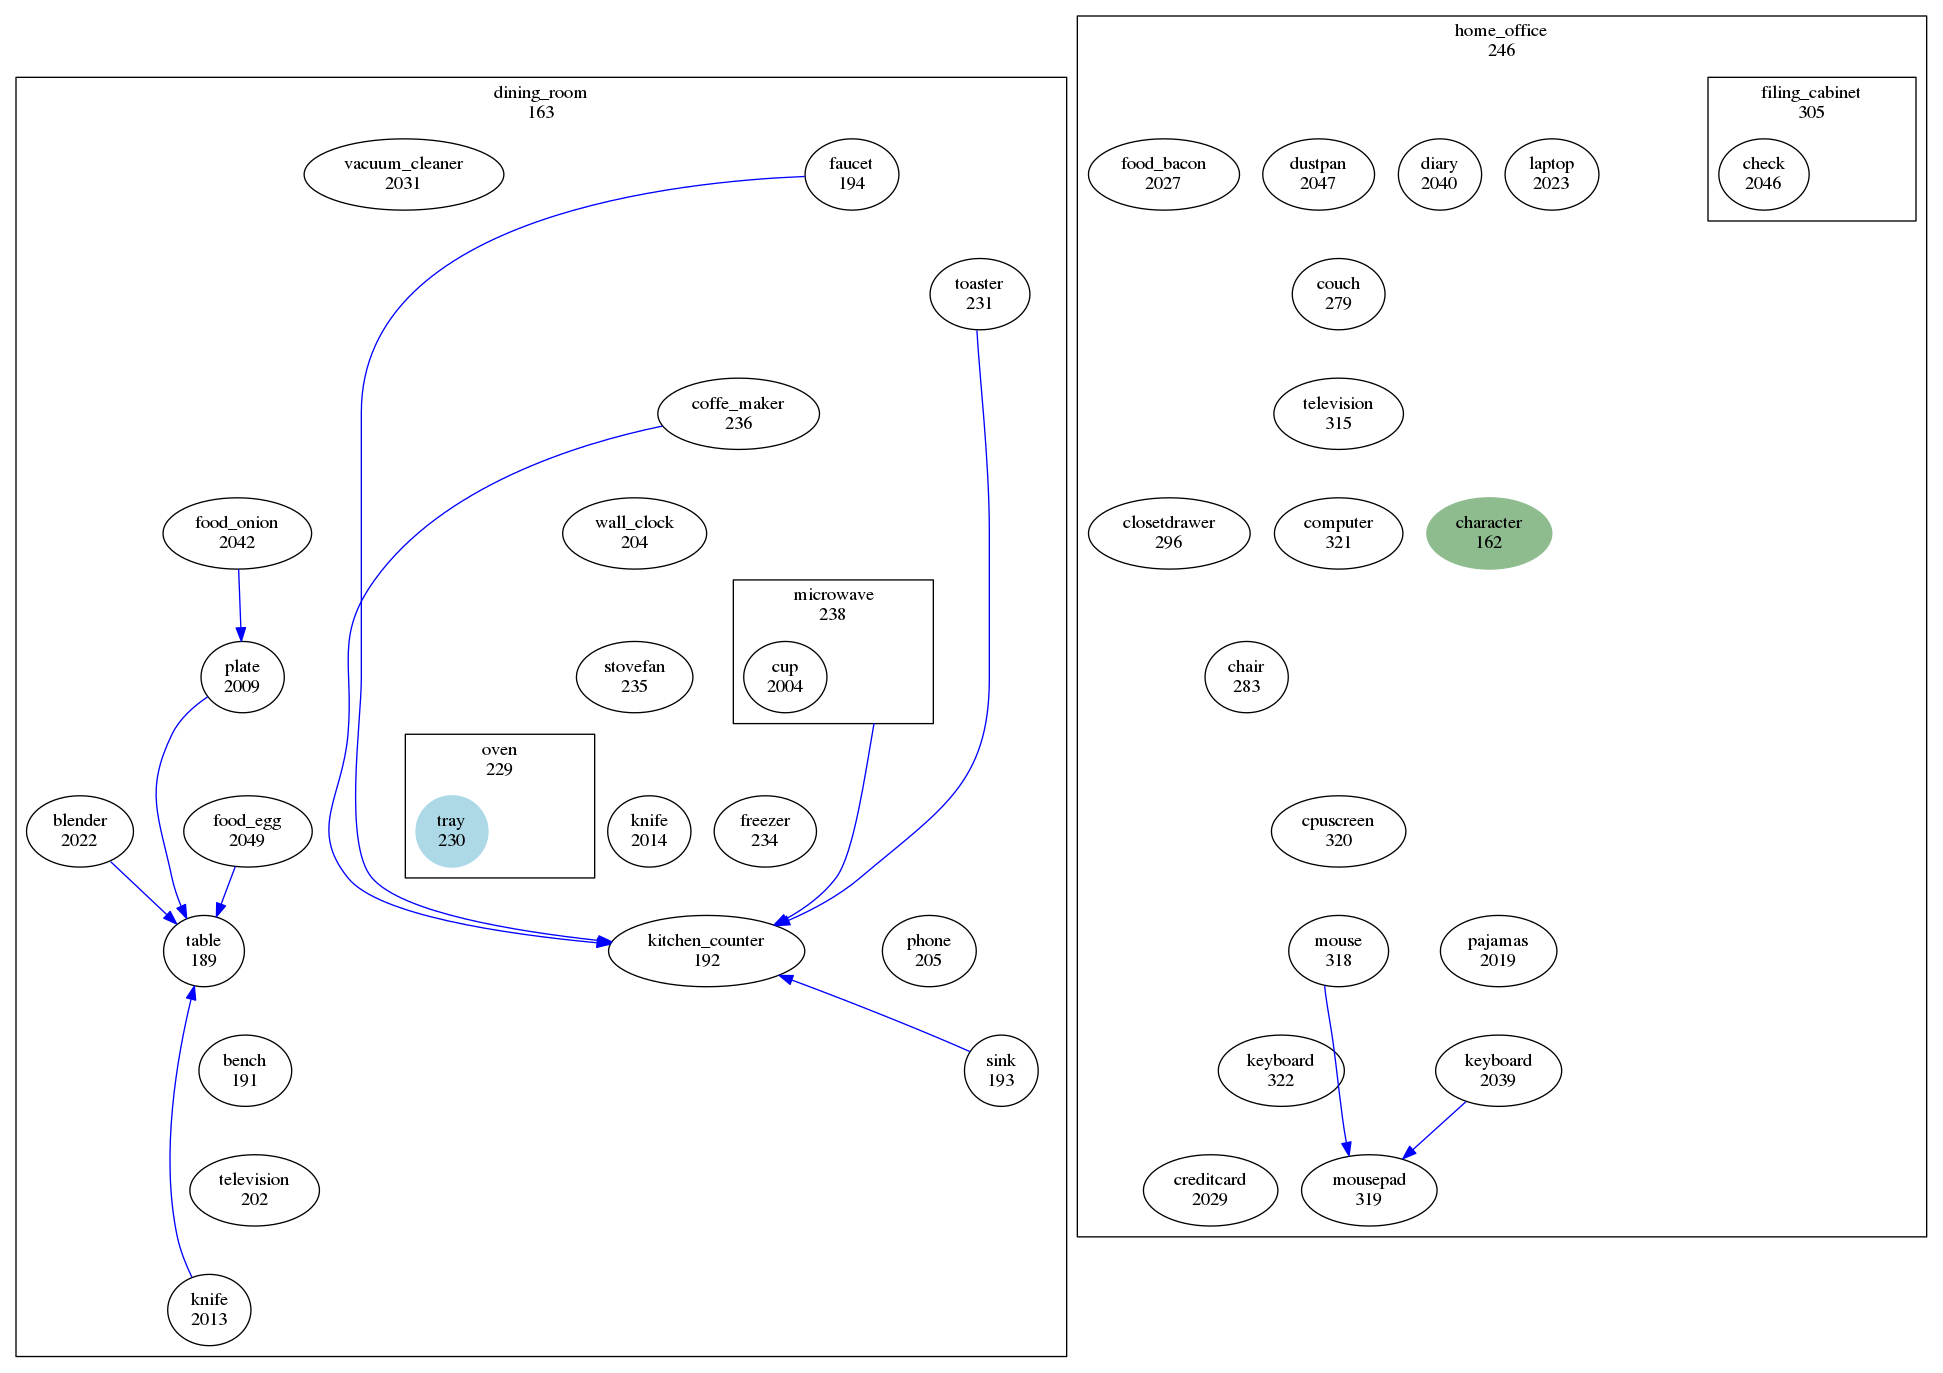

In [171]:
path_init_env = 'dataset_toy4/init_envs/TrimmedTestScene6_graph_45.json'
id_goal = 230
str_goal = 'findnode_{}'.format(id_goal)
id_agent = 162
args = utils.read_args()
args.max_steps = 1
args.dataset_folder = 'dataset_toy4'
args.interactive = True
dataset_interactive = envdataset.EnvDataset(args, process_progs=False)
print('Starting model...')
policy_net = SinglePolicy(dataset_interactive).cuda()
policy_net = torch.nn.DataParallel(policy_net)


goal_name = {0:'(facing living_room[1] living_room[1])'}
curr_env.reset(path_init_env, goal_name)
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)
single_agent.env.reset(path_init_env, goal_name)
weights = 'logdir/dataset_folder.dataset_toy4_pomdp.False_graphsteps.3_training_mode.pg/offp.False_eps.0.2_gamma.0.7/2019-11-14_00.45.32.080556/chkpt/chkpt_149.pt'
single_agent.policy_net.load_state_dict(torch.load(weights)['model_params'])
single_agent.env.reset(path_init_env, goal_name)
gt_state = single_agent.env.vh_state.to_dict()
graph = utils_viz.graph2im(gt_state, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

## Correct belief

In [790]:
single_agent.env.reset(path_init_env, goal_name)
print(str_goal)
for i in range(5):
    curr_state = single_agent.env.vh_state.to_dict()
    visible_ids = single_agent.env.observable_object_ids_n[0]
    graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(
                curr_state, visible_ids, str_goal)
    instruction, logits = single_agent.sample_instruction(single_agent.dataset, graph_data,
                                                  action_logits, o1_logits, o2_logits)
    instr = list(zip(*instruction))[0]
    str_instruction = utils.pretty_instr(instr)
    print(str_instruction)
    resp = single_agent.env.step({0: str_instruction})

findnode_230
[walk] <dining_room> (163) 
[walk] <oven> (229) 
[open] <oven> (229) 
[walk] <plate> (2009) 
[walk] <home_office> (246) 


In [791]:
from vh_graph.envs import belief

### Wrong belief


In [910]:
id_goal = 2029
str_goal = 'findnode_{}'.format(id_goal)
single_agent.previous_belief_graph = None
single_agent.env.reset(path_init_env, goal_name)
print(str_goal)
gt_state = single_agent.env.vh_state.to_dict()
obs_graph = single_agent.get_observations()

findnode_2029


Edges...


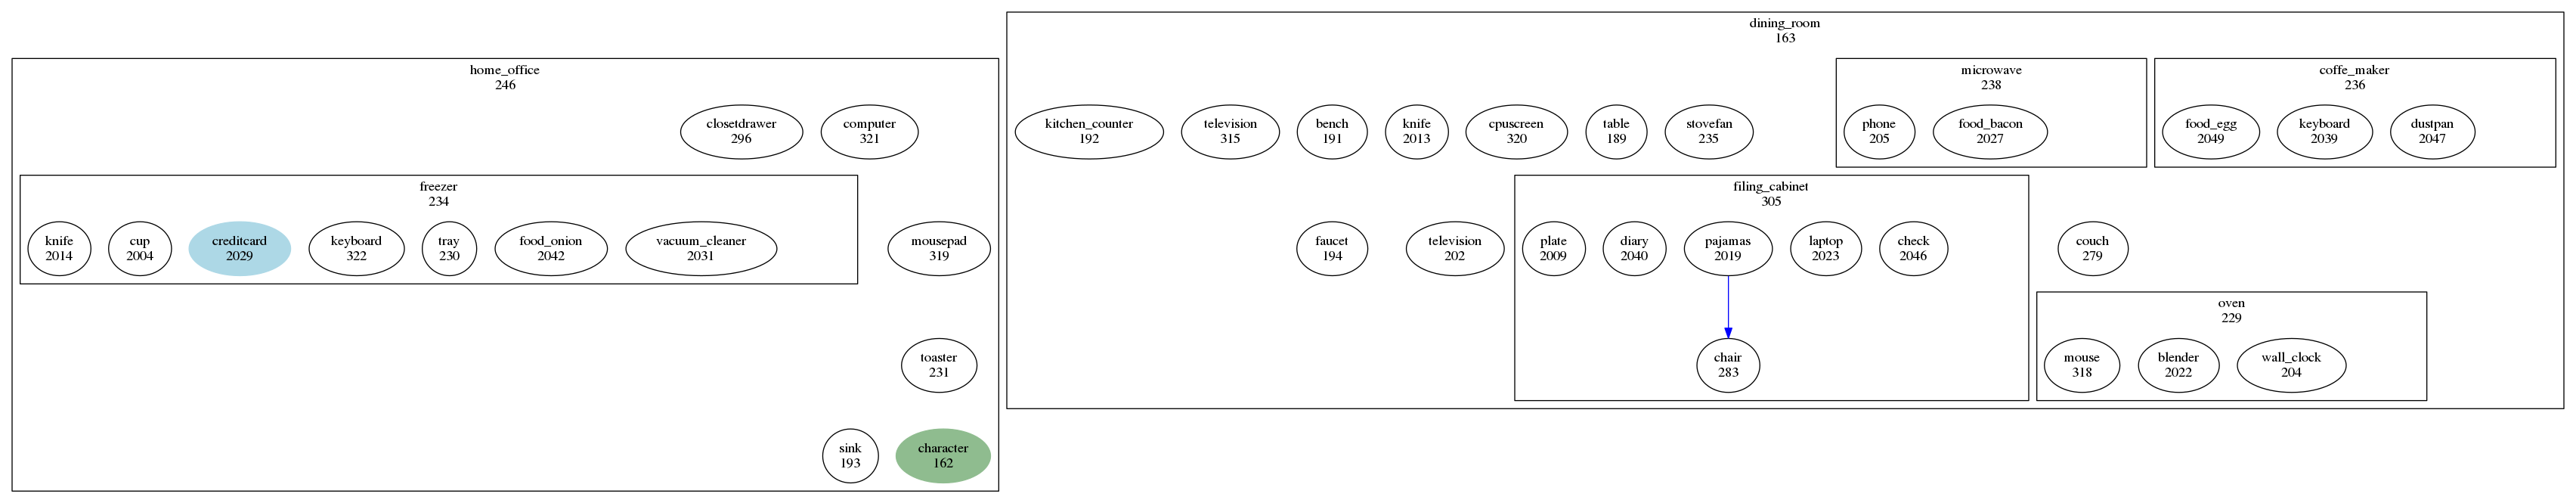

In [911]:
import numpy as np
import random
seed = 869
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
single_agent.previous_belief_graph = None
obs_graph = single_agent.get_observations()
single_agent.sample_belief(obs_graph)

graph = utils_viz.graph2im(single_agent.belief_sim.vh_state.to_dict(), {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))


In [912]:
# str_goal = 'findnode_230'

# curr_state = single_agent.belief_sim.vh_state.to_dict()
# visible_ids = single_agent.belief_sim.observable_object_ids_n[0]
# print(visible_ids)
# graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(
#         curr_state, visible_ids, str_goal)
# instruction, logits = single_agent.sample_instruction(single_agent.dataset, graph_data,
#                                           action_logits, o1_logits, o2_logits)
# instr = list(zip(*instruction))[0]
# str_instruction = utils.pretty_instr(instr)
# _ = single_agent.belief_sim.step({0: str_instruction})
# _ = single_agent.env.step({0: str_instruction})

In [915]:
for i in range(1):
    _, instruction, _, _, _ = single_agent.one_step_rollout(str_goal, False, use_belief=True)
    graph_belief = single_agent.belief_sim.vh_state.to_dict()
    edge_interest = [x for x in graph_belief['edges'] if x['from_id'] == id_goal and x['relation_type'] != 'CLOSE']
    print(instruction, edge_interest)

[walk] <home_office> (246)  [{'from_id': 2029, 'relation_type': 'INSIDE', 'to_id': 246}]


In [475]:
_, instruction, _, _, _ = single_agent.one_step_rollout(str_goal, False, use_belief=True)
print(instruction)
graph_belief = single_agent.belief_sim.vh_state.to_dict()
edge_interest = [x for x in graph_belief['edges'] if x['from_id'] == 230]
print(edge_interest)

[walk] <oven> (229) 
[{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 234}]


In [464]:
_, instruction, _, _, _ = single_agent.one_step_rollout(str_goal, False, use_belief=True)
print(instruction)
graph_belief = single_agent.belief_sim.vh_state.to_dict()
edge_interest = [x for x in graph_belief['edges'] if x['from_id'] == 230]
print(edge_interest)

[walk] <toaster> (231) 
[{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 234}]


## State from belief

Edges...


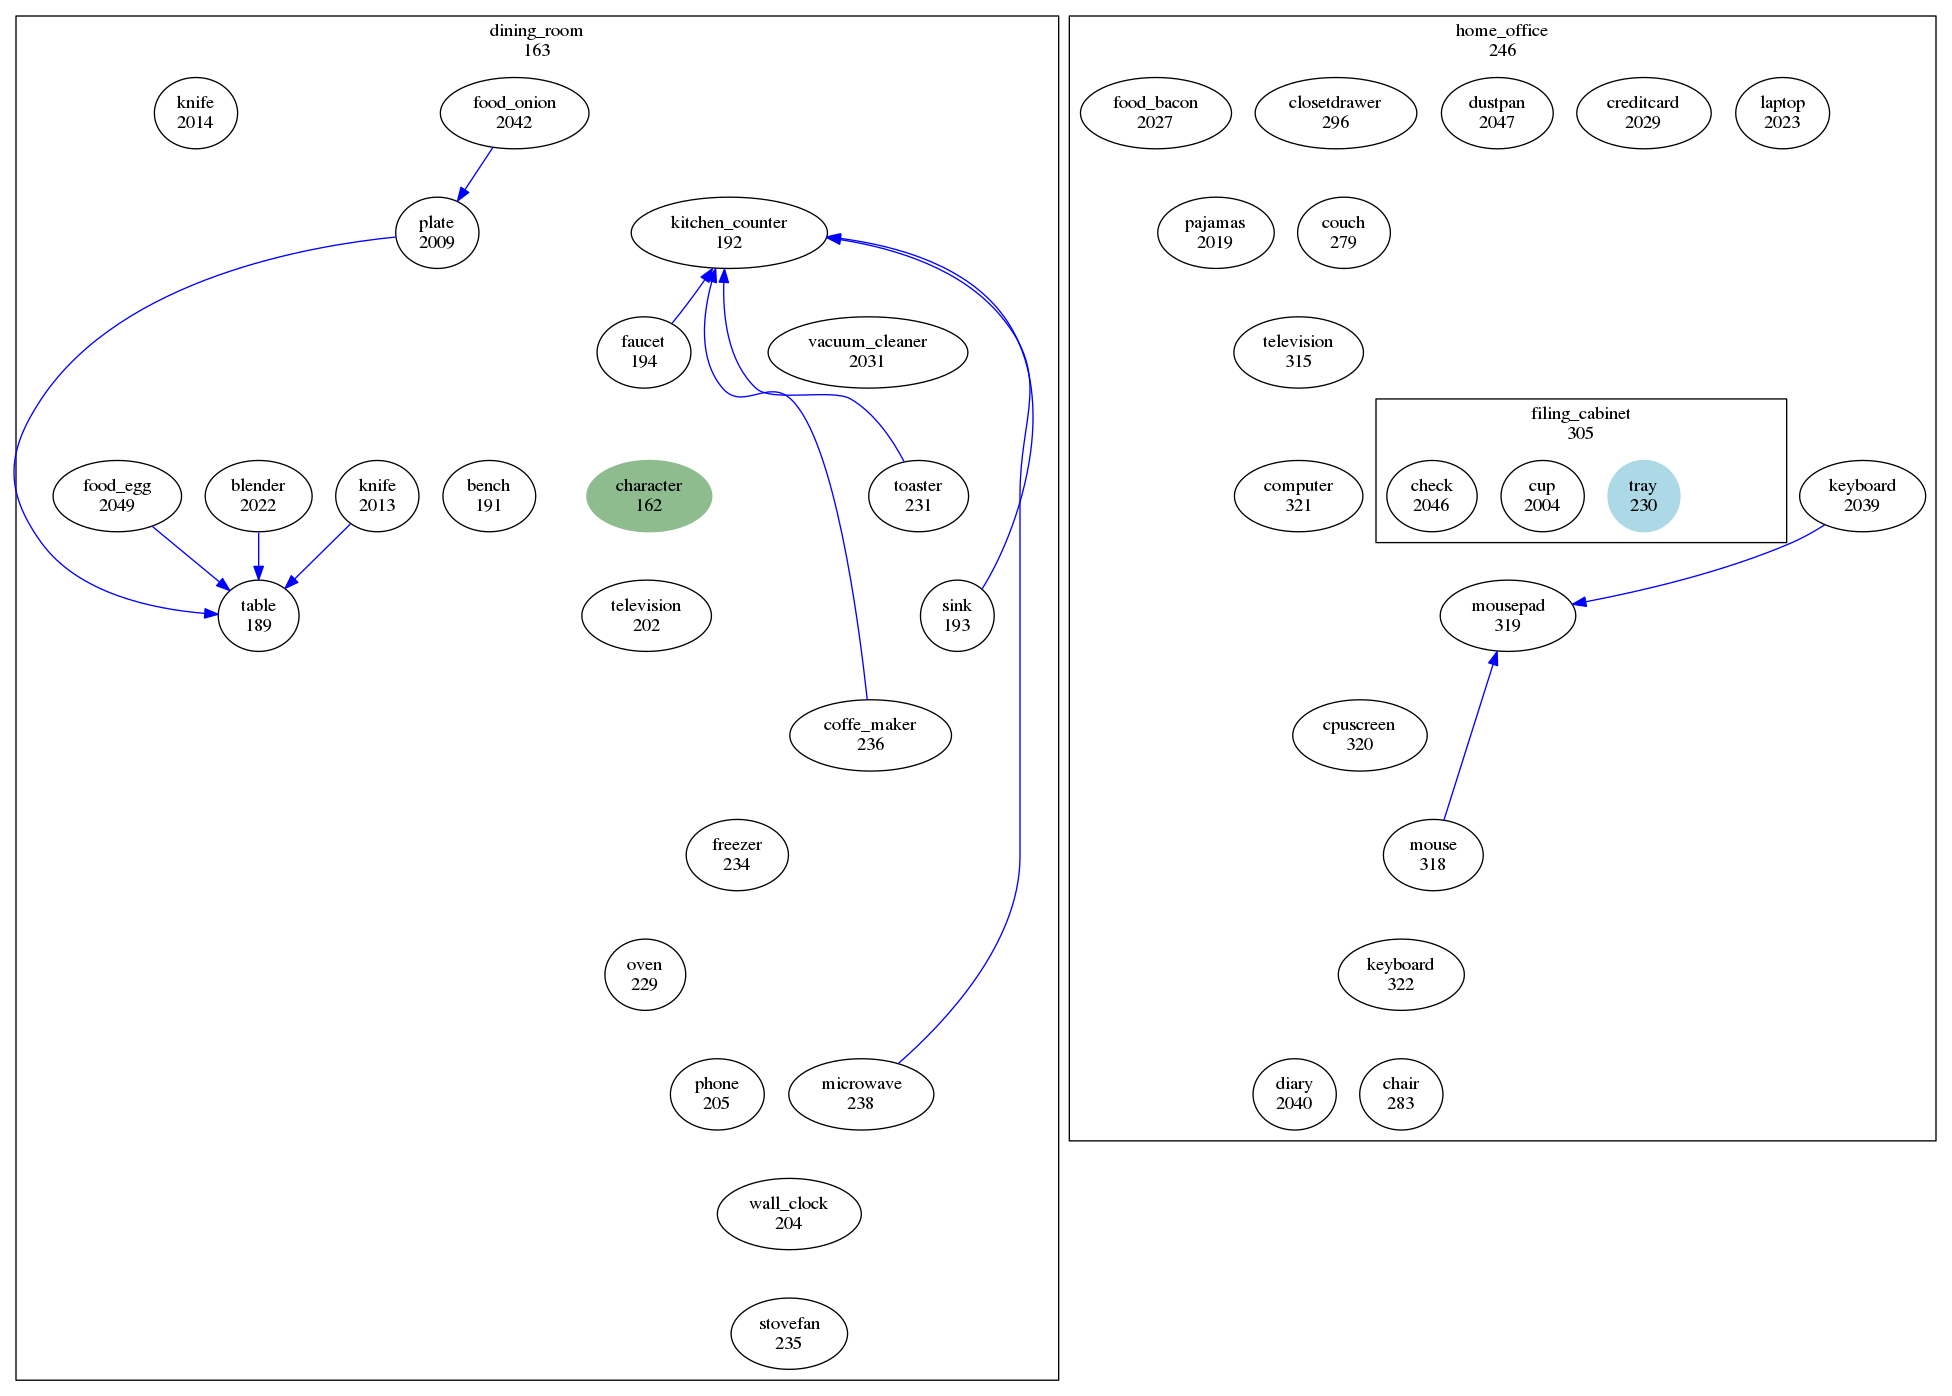

In [847]:
obs_graph = single_agent.get_observations()
single_agent.sample_belief(obs_graph)

graph_belief = single_agent.belief_sim.vh_state.to_dict()
graph = utils_viz.graph2im(graph_belief, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

Edges...
CLOSE_CHAR


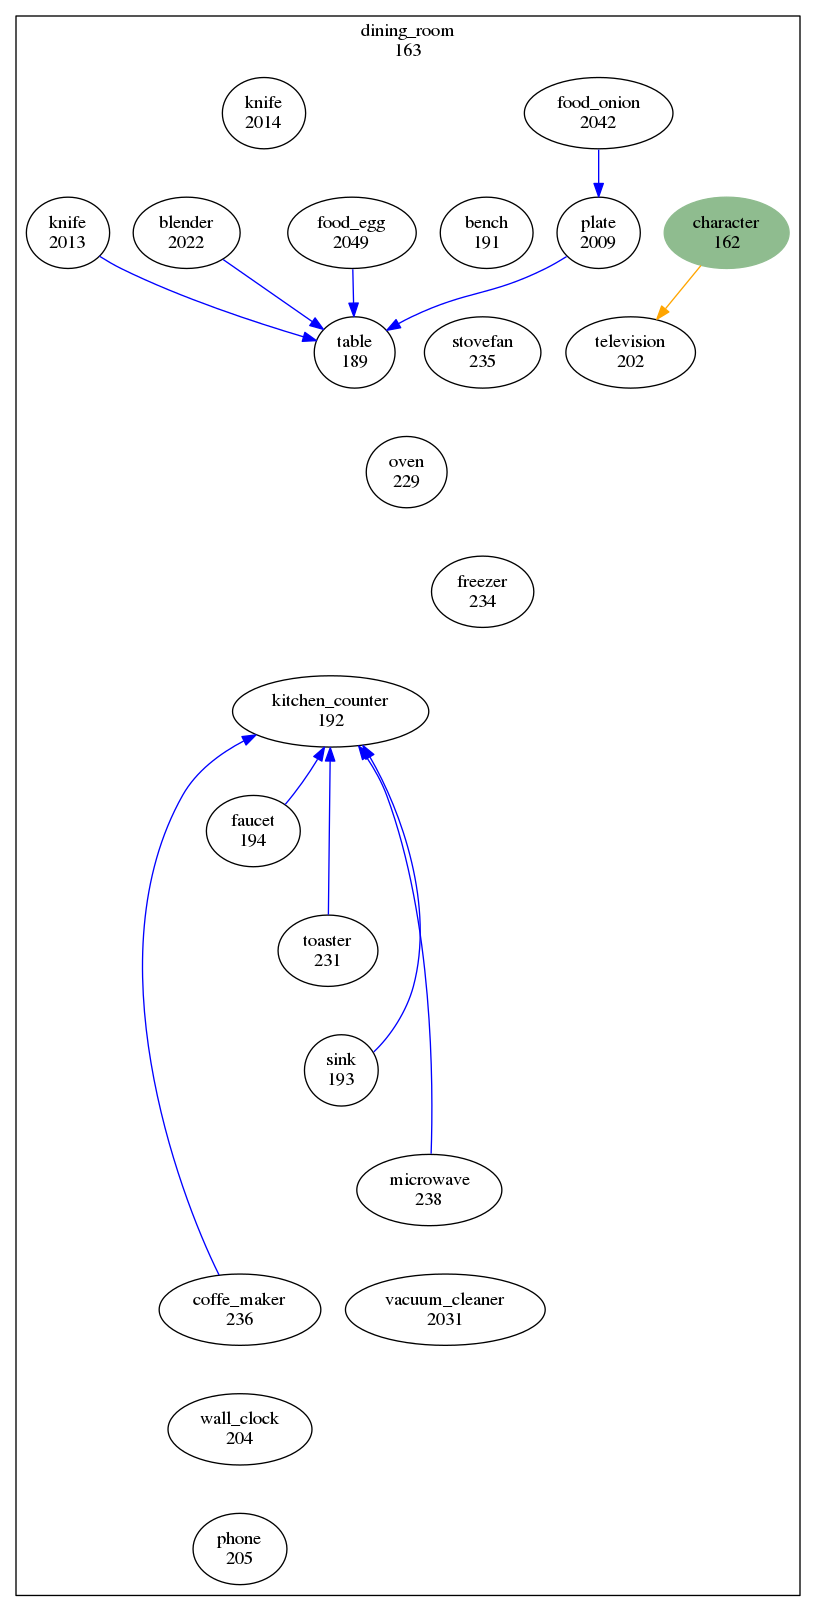

In [569]:
observations = single_agent.get_observations()
#single_agent.sample_belief(observations)
graph_belief = single_agent.belief_sim.vh_state.to_dict()

obs_graph = single_agent.belief_sim.vh_state.to_dict()
graph = utils_viz.graph2im(observations, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

In [39]:
resp = env_belief.step({0: str_instruction})

Edges...
CLOSE_CHAR


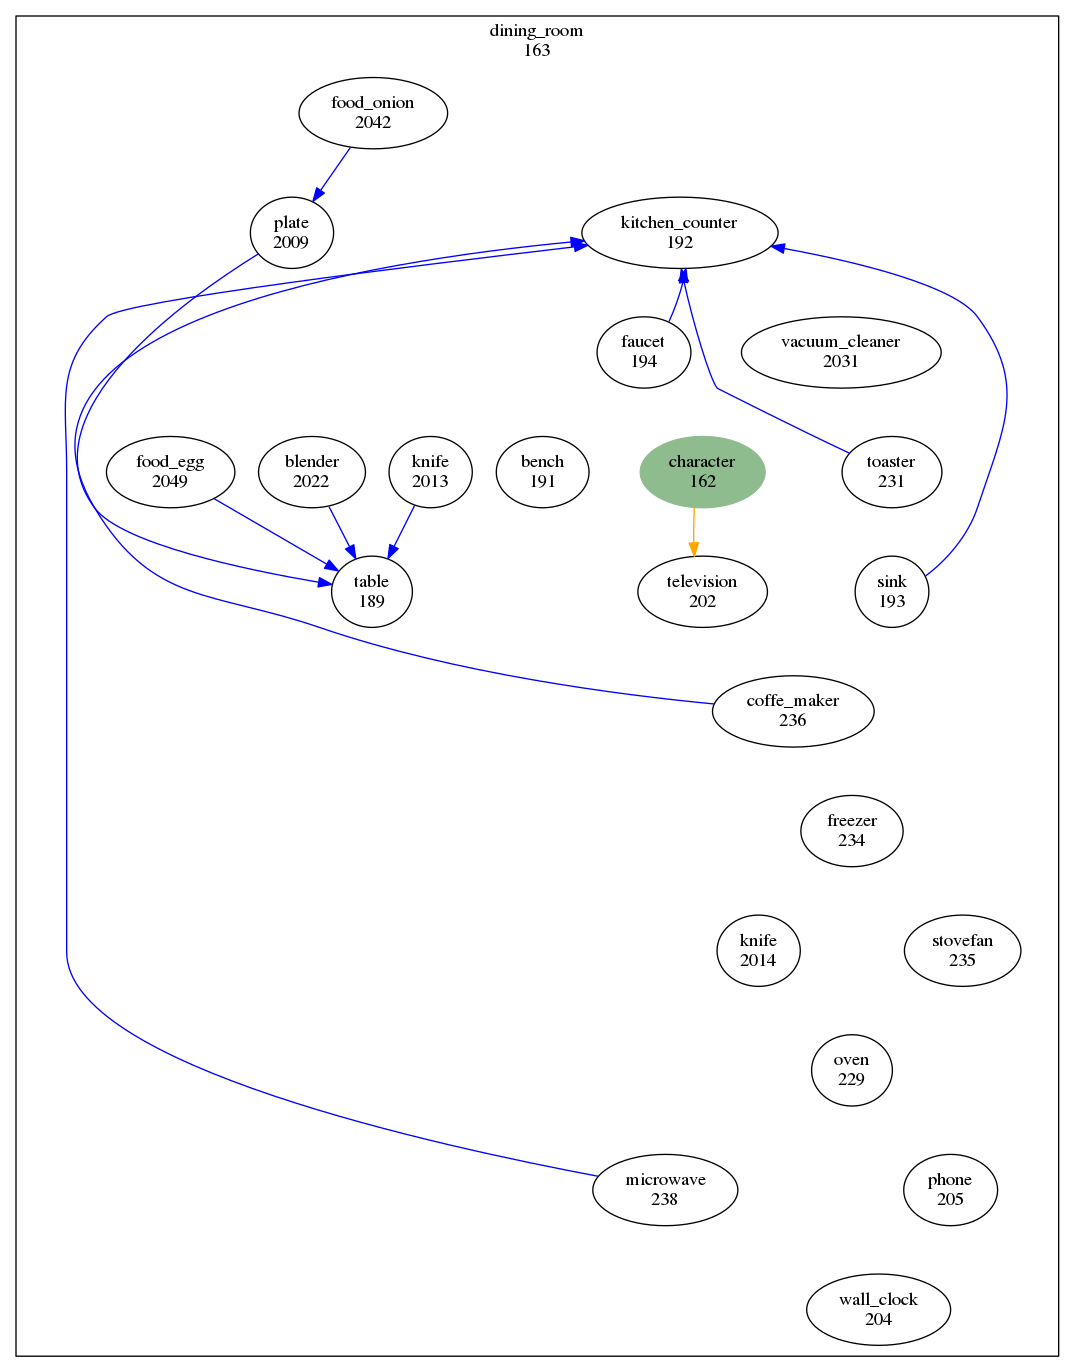

In [568]:

obs_graph = single_agent.get_observations()
#print(obs_graph)
graph = utils_viz.graph2im(obs_graph, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))
import copy
curr_state_save = copy.deepcopy(curr_state)

In [41]:
curr_state = bel.update_graph_from_gt_graph(curr_state, obs_graph)

In [23]:
[x for x in obs_graph['nodes'] if x['id'] == 189]

[{'id': 189,
  'class_name': 'table',
  'category': 'Furniture',
  'properties': ['MOVABLE', 'SURFACES'],
  'states': [],
  'prefab_name': None,
  'bounding_box': None}]

In [203]:
curr_state = copy.deepcopy(curr_state_save)

### Multiple step rollout

In [ ]:
def one_step_rollout(env, goal_string, pomdp):
    if pomdp:
        curr_state = single_agent.get_observations()
        visible_ids = None
    else:
        curr_state = single_agent.env.vh_state.to_dict()
        visible_ids = single_agent.env.observable_object_ids_n[0]
    
    graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(curr_state, visible_ids, goal_string)
    instruction, logits = single_agent.sample_instruction(dataset_interactive, graph_data, 
                                                          action_logits, o1_logits, o2_logits, pick_max=True)
    #instruction = single_agent.get_top_instruction(dataset_interactive, graph_data, action_logits, o1_logits, o2_logits)
    logits = None
    instr = list(zip(*instruction))[0]
    str_instruction = utils.pretty_instr(instr)
    if 'stop' in str_instruction:
            return None, str_instruction, logits
    resp = single_agent.env.step({0: str_instruction})
    return resp, str_instruction, logits

In [ ]:
args.pomdp = False
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.False_graphsteps.3/2019-11-06_09.14.31.202175/chkpt/chkpt_49.pt'
state_dict = torch.load(weights)
single_agent.policy_net.load_state_dict(state_dict['model_params'])

curr_env.reset(path_init_env, goal_name)
max_instr = 0
instr = ''
goal_str = 'findnode_315'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

In [ ]:
curr_env.reset(path_init_env, goal_name)
max_instr = 0
instr = ''
goal_str = 'findnode_301'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

### Back to non POMDP

In [ ]:
%autoreload 2

In [ ]:

path_init_env = "dataset_toy3/init_envs/TrimmedTestScene6_graph_28.json"
goal_name = '(facing living_room[1] living_room[1])'
curr_env.reset(path_init_env, {0: goal_name})
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)

# Starting the scene
curr_state = single_agent.get_observations()
gt_state = single_agent.env.vh_state.to_dict()

# All the nodes
nodes, _, ids_used = dataset_interactive.process_graph(gt_state)
class_names, object_ids, _, mask_nodes, _ = nodes

In [ ]:
graph = utils_viz.graph2im(gt_state, {320: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

In [ ]:
args.pomdp = False
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.False_graphsteps.3/2019-11-06_09.14.31.202175/chkpt/chkpt_49.pt'
state_dict = torch.load(weights)
single_agent.policy_net.load_state_dict(state_dict['model_params'])
curr_env.reset(path_init_env, {0:goal_name})
max_instr = 0
instr = ''
goal_str = 'findnode_320'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

In [ ]:
args.pomdp = True
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.True_graphsteps.3/2019-11-06_09.13.35.555005/chkpt/chkpt_49.pt'
state_dict = torch.load(weights)
single_agent.policy_net.load_state_dict(state_dict['model_params'])
curr_env.reset(path_init_env, {0:goal_name})
max_instr = 0
instr = ''
goal_str = 'findnode_320'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

> /data/vision/torralba/frames/data_acquisition/SyntheticStories/MultiAgent/vh_multiagent_models/utils_viz.py(110)graph2im()
-> if curr_subgraph_id not in parent:
(Pdb) c
Edges...
CLOSE_CHAR
CLOSE_CHAR


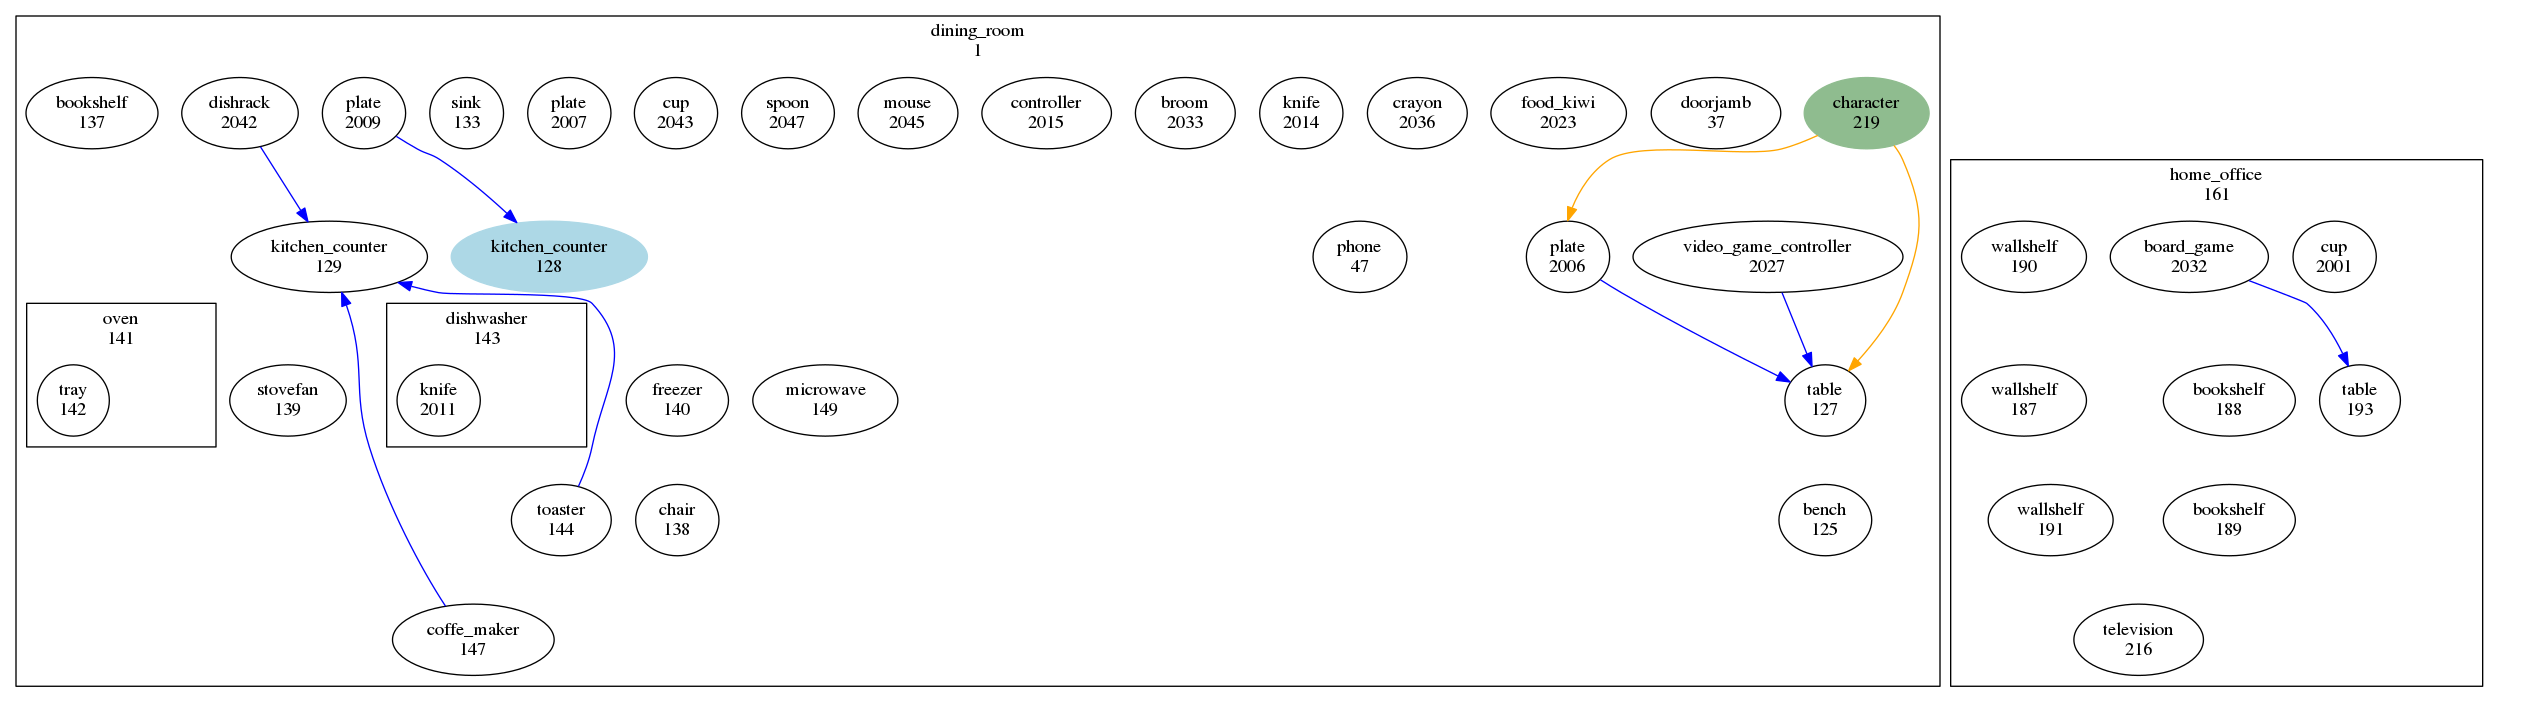

In [17]:
import json
time = 2
goal_name = '(facing living_room[1] living_room[1])'
with open('dataset_toy4/init_envs/TrimmedTestScene3_graph_31_multiple_21.json', 'r') as f:
    graph_multiple = json.load(f)

gt_state = graph_multiple[time][1]
id_agent = [x['id'] for x in gt_state['nodes'] if x['class_name'] == 'character'][0]
graph = utils_viz.graph2im(gt_state, {128: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

In [15]:
reload(utils_viz)

NameError: name 'reload' is not defined

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
bel.update_from_gt_graph

<bound method Belief.update_from_gt_graph of <vh_graph.envs.belief.Belief object at 0x7f6d7d0b1860>>